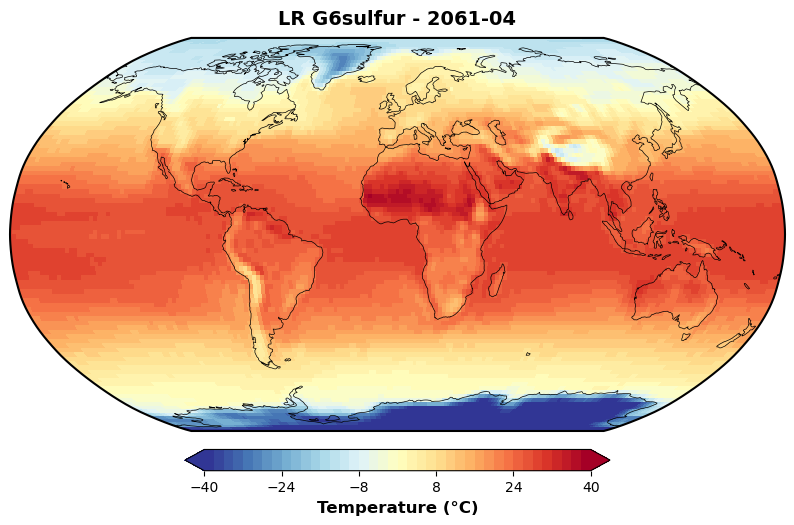

Saved: Figures/XHR/lr.png


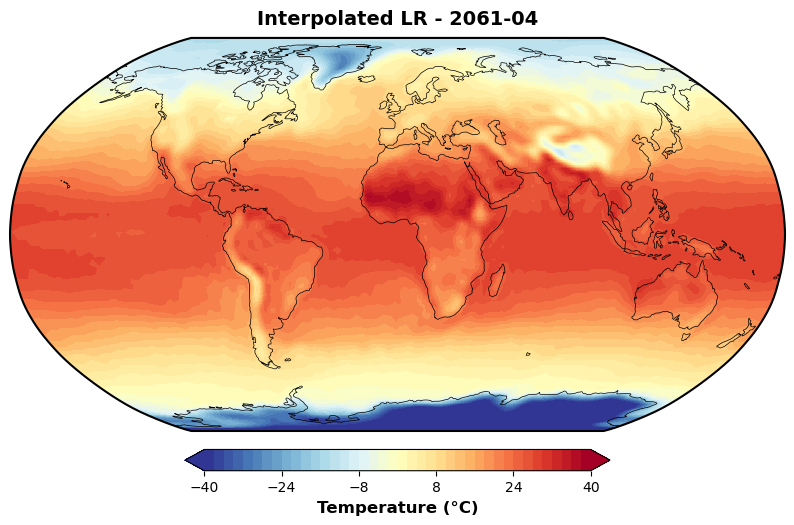

Saved: Figures/XHR/interp.png


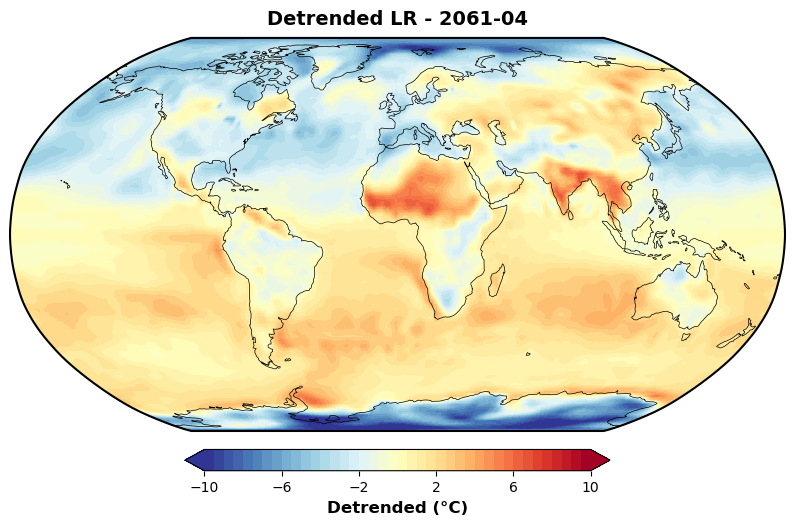

Saved: Figures/XHR/detrend.png


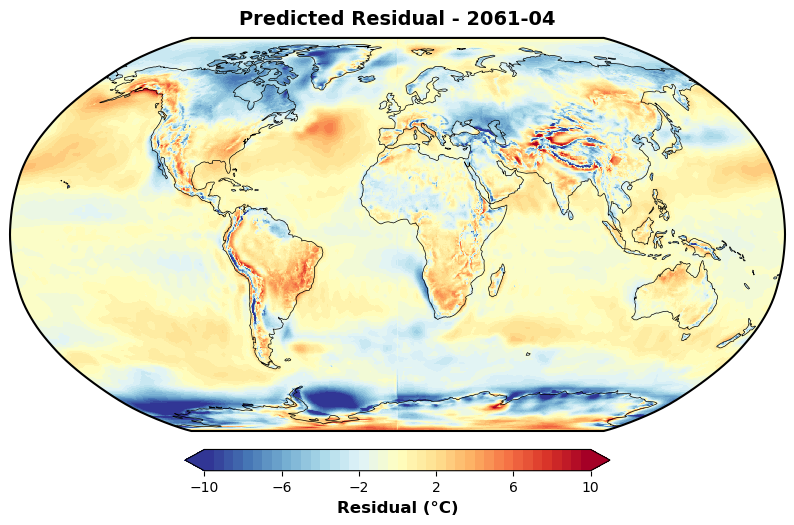

Saved: Figures/XHR/residual.png


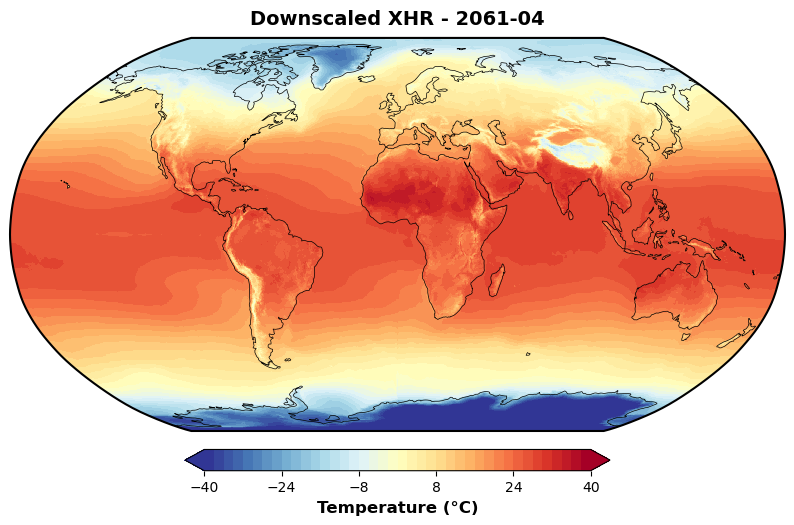

Saved: Figures/XHR/downscaled.png

All figures saved!


In [56]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
from matplotlib.colors import BoundaryNorm

# Load data
results = xr.open_dataset("evaluation_results_xhr/g6sulfur_downscaled_xhr.nc")
g6_lr = xr.open_dataset("data/cmip6/g6sulfur_lr_tas_monthly_2015_2100.nc")
g6_detrend = xr.open_dataset("data/cmip6/g6_test_detrend_xhr.nc")['__xarray_dataarray_variable__']

# Create output directory
output_dir = Path("Figures/XHR")
output_dir.mkdir(parents=True, exist_ok=True)

# Time index
t = 555

# Get time string for title (Year-Month)
time_val = results['time'].isel(time=t).values
time_str = str(time_val)[:7]  # Extract YYYY-MM

# Extract data: single time index, convert K to °C
data_dict = {
    'lr': g6_lr['tas'].isel(time=t).values - 273.15,
    'interp': results['tas_cmip6_interp'].isel(time=t).values - 273.15,
    'residual': results['tas_residual_pred'].isel(time=t).values,  # Already anomaly
    'downscaled': results['tas_downscaled'].isel(time=t).values - 273.15,
    'detrend': g6_detrend.isel(time=t).values  # Already anomaly
}

# Get coordinates
lat = results['lat'].values
lon = results['lon'].values
lat_lr = g6_lr['lat'].values
lon_lr = g6_lr['lon'].values
lat_detrend = g6_detrend['lat'].values
lon_detrend = g6_detrend['lon'].values

# Manual vmin/vmax
vmin, vmax = -40, 40
vmin_res, vmax_res = -10, 10
vmin_detrend, vmax_detrend = -10, 10

# Create discrete norms (40 intervals = 41 boundaries)
bounds_temp = np.linspace(vmin, vmax, 41)
bounds_res = np.linspace(vmin_res, vmax_res, 41)
bounds_detrend = np.linspace(vmin_detrend, vmax_detrend, 41)

cmap = plt.cm.RdYlBu_r
norm_temp = BoundaryNorm(bounds_temp, cmap.N)
norm_res = BoundaryNorm(bounds_res, cmap.N)
norm_detrend = BoundaryNorm(bounds_detrend, cmap.N)

# Plotting function with colorbar
def plot_robinson(data, lat, lon, filename, norm, bounds, cbar_label='', title=''):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    
    lon_2d, lat_2d = np.meshgrid(lon, lat)
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm,
                       shading='auto')
    
    ax.coastlines(linewidth=0.5)
    ax.set_global()
    
    # Add black edge around the globe
    ax.spines['geo'].set_edgecolor('black')
    ax.spines['geo'].set_linewidth(1.5)
    
    # Add title
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    # Add colorbar with extend='both' to show triangular ends for out-of-range values
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', 
                        fraction=0.046, pad=0.04, shrink=0.6,
                        ticks=bounds[::8], extend='both')  # Show every 8th tick
    cbar.set_label(cbar_label, fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    print(f"Saved: {filename}")

# Plot each field
plot_robinson(data_dict['lr'], lat_lr, lon_lr, 
              output_dir / "lr.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'LR G6sulfur - {time_str}')

plot_robinson(data_dict['interp'], lat, lon, 
              output_dir / "interp.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'Interpolated LR - {time_str}')

plot_robinson(data_dict['detrend'], lat_detrend, lon_detrend, 
              output_dir / "detrend.png", norm_detrend, bounds_detrend,
              cbar_label='Temperature (°C)', title=f'Detrended LR - {time_str}')

plot_robinson(data_dict['residual'], lat, lon, 
              output_dir / "residual.png", norm_res, bounds_res,
              cbar_label='Temperature (°C)', title=f'Predicted Residual - {time_str}')

plot_robinson(data_dict['downscaled'], lat, lon, 
              output_dir / "downscaled.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'Downscaled XHR - {time_str}')

print("\nAll figures saved!")

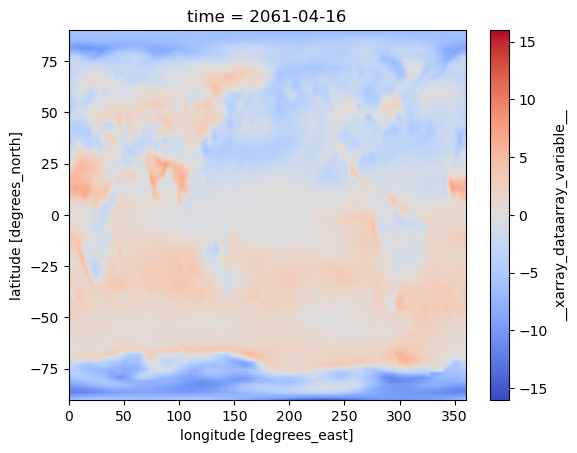

In [43]:

g6_detrend.isel(time=555).plot(cmap='coolwarm',vmin=-16,vmax=16)

In [10]:
vmax

311.47635

In [11]:
vmin_res

-19.486694765148002

In [12]:
vmax_res

19.486694765148002

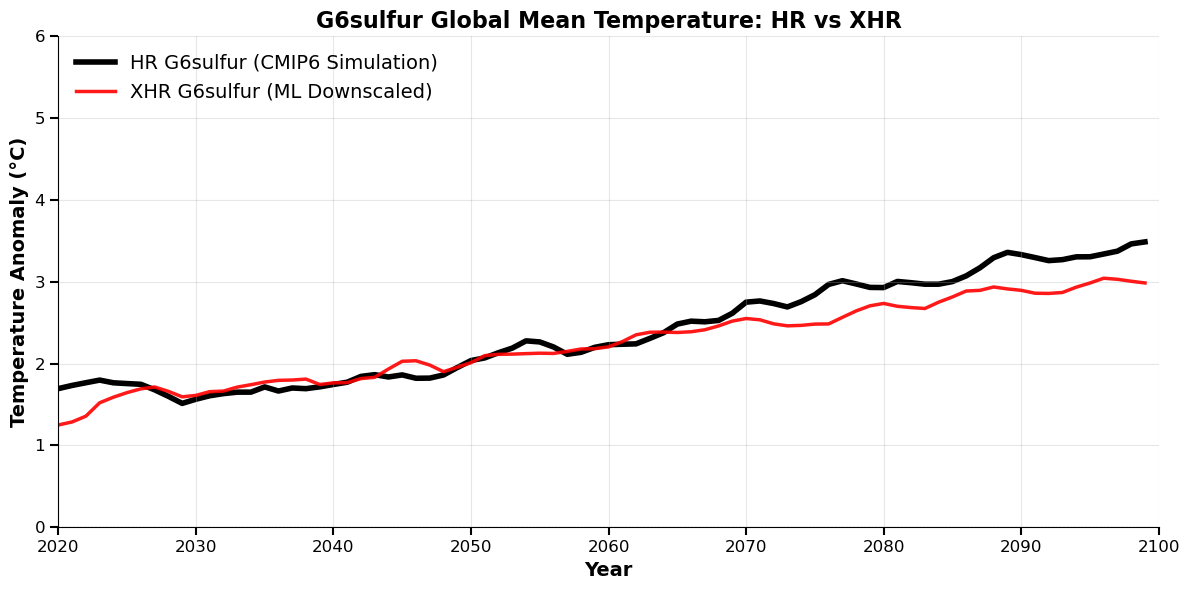

Figure saved!


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
figures_dir = Path("Figures/XHR")
figures_dir.mkdir(parents=True, exist_ok=True)

# Load HR G6sulfur (groundtruth from evaluation results)
hr_file = Path("evaluation_results/tas_evaluation_g6sulfur.nc")
ds_hr = xr.open_dataset(hr_file)

# Load XHR G6sulfur (downscaled results)
xhr_file = Path("evaluation_results_xhr/g6sulfur_downscaled_xhr.nc")
ds_xhr = xr.open_dataset(xhr_file)

# Load historical for baseline calculation
hist_file = Path("data/MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_hist = xr.open_dataset(hist_file)

def calc_baseline(ds, var='tas_hr', start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    data = ds[var]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baseline (in °C)
baseline = calc_baseline(ds_hist, 'tas_hr', 1850, 1900)

# Process HR G6sulfur
time_slice = slice('2020', '2099')
hr_data = ds_hr['groundtruth'].sel(time=time_slice).values
hr_time = ds_hr['groundtruth'].sel(time=time_slice).time

hr_mean = calc_global_mean(hr_data) - baseline
years_hr, hr_annual = to_annual_mean(hr_mean, hr_time)
hr_smooth = smooth_data(hr_annual, window=3)

# Process XHR G6sulfur (convert K to °C)
xhr_data = ds_xhr['tas_downscaled'].sel(time=time_slice).values - 273.15  # K to °C
xhr_time = ds_xhr['tas_downscaled'].sel(time=time_slice).time

xhr_mean = calc_global_mean(xhr_data) - baseline
years_xhr, xhr_annual = to_annual_mean(xhr_mean, xhr_time)
xhr_smooth = smooth_data(xhr_annual, window=3)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(years_hr, hr_smooth, 
        color='black', linestyle='-', linewidth=4,
        label='HR G6sulfur (CMIP6 Simulation)', zorder=1)

ax.plot(years_xhr, xhr_smooth, 
        color='red', linestyle='-', linewidth=2.5,
        label='XHR G6sulfur (ML Downscaled)', alpha=0.9, zorder=2)

# Format
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, 7, 1))
ax.set_xlim(2020, 2100)

ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperature Anomaly (°C)', fontsize=14, fontweight='bold')
ax.set_title('G6sulfur Global Mean Temperature: HR vs XHR', fontsize=16, fontweight='bold')

ax.legend(loc='upper left', fontsize=14, frameon=False)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=12, length=6, width=1.5)

plt.tight_layout()
plt.savefig(figures_dir / "g6sulfur_hr_xhr_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Close datasets
ds_hr.close()
ds_xhr.close()
ds_hist.close()

print("Figure saved!")